In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sympy
from sympy import init_printing
init_printing()
from celmech import Poincare,PoincareHamiltonian
from celmech.nbody_simulation_utilities import align_simulation

from celmech.secular import LaplaceLagrangeSystem, SecularSystemSimulation
import rebound as rb
COMPARE = False # Set true to compare numerical results from operator to sympy

In [2]:
def get_sim(scale= 0.05):
    sim = rb.Simulation()
    sim.add(m=1)
    for i in range(1,4):
        sim.add(m=i * 1e-5 , a = 2**i, 
                e = np.random.rayleigh(scale),
                inc = np.random.rayleigh(scale),
                l = 'uniform',
                pomega = 'uniform',
                Omega = 'uniform'
               )
    sim.move_to_com()
    align_simulation(sim)
    return sim

# Initialize simulation objects and evolution operators

In [3]:
np.random.seed(0)


#sim = get_sim()
sa  = rb.SimulationArchive('./sa_secular.bin')
sim = sa[0]
pvars = Poincare.from_Simulation(sim)
llsys = LaplaceLagrangeSystem.from_Poincare(pvars)
sec_sim = SecularSystemSimulation(state=pvars,dtFraction= (1 / 150) , max_order=4, DFOp_kwargs={'rtol':1e-10})

# Integration

## numerical secular model

In [4]:
Tfin = sec_sim.dt * 3e3
N = 200

In [5]:
def run_secular_sim(sec_sim,times):
    N = len(times)
    eccN,incN = np.zeros((2,sec_sim.state.N - 1,N))
    EnergyN = np.zeros(N)
    amdN = np.zeros(N)
    timesDone = np.zeros(N)
    for i,time in enumerate(times):
        sec_sim.integrate(time)
        timesDone[i] = sec_sim.t
        EnergyN[i] = sec_sim.calculate_energy()
        amdN[i] = sec_sim.calculate_AMD()
        for j,p in enumerate(sec_sim.state.particles[1:]):
            eccN[j,i] = p.e
            incN[j,i] = p.inc
    return timesDone,EnergyN,amdN,eccN,incN

In [6]:
T = np.linspace(0,Tfin,N)
%time times,EnergyN,amdN,eccN,incN = run_secular_sim(sec_sim,T)

CPU times: user 6.09 s, sys: 93.9 ms, total: 6.19 s
Wall time: 6.29 s


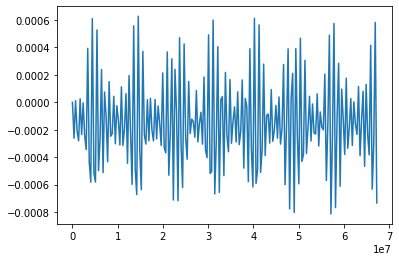

In [7]:
plt.plot(times,(EnergyN - EnergyN[0]) / EnergyN[0])

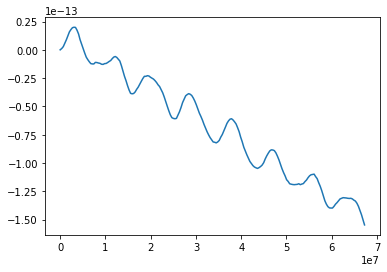

In [8]:
plt.plot(times,(amdN - amdN[0]) / amdN[0])

## $N$-body

In [14]:
from celmech.nbody_simulation_utilities import set_timestep,get_simarchive_integration_results
sim.integrator = 'whfast'
set_timestep(sim,1/30.)
sim.ri_whfast.safe_mode=0
sim.automateSimulationArchive('sa_secular.bin',interval=times[1],deletefile=True)
%time sim.integrate(times[-1])

CPU times: user 1min 9s, sys: 566 ms, total: 1min 9s
Wall time: 1min 11s


In [23]:
sa =rb.SimulationArchive('sa_secular.bin')
nbody_results = get_simarchive_integration_results(sa)

## Laplace-Lagrange solution

In [20]:
llsoln = llsys.secular_solution(times)

## Comparison

In [21]:
Tsec = llsys.Tsec

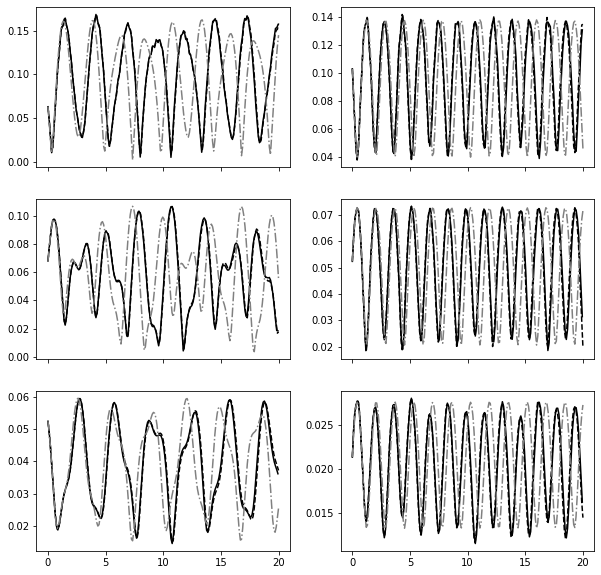

In [24]:
fig,ax = plt.subplots(3,2,figsize=(10,10),sharex=True)
for i in range(3):
    ax[i,0].plot(nbody_results['time']/Tsec,nbody_results['e'][i],color='k')
    ax[i,0].plot(times/Tsec,eccN[i],'--',color='k')
    ax[i,0].plot(times/Tsec,llsoln['e'][i],ls='-.',color='gray')
    
    ax[i,1].plot(nbody_results['time']/Tsec,nbody_results['inc'][i],color='k')
    ax[i,1].plot(times/Tsec,incN[i],'--',color='k')
    ax[i,1].plot(times/Tsec,llsoln['inc'][i],ls='-.',color='gray')